### 1 - Import test data

In [1]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tqdm.pandas()

def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    df["Gmt time"] = df["Gmt time"].str.replace(".000", "")
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
    df = df[df.High != df.Low]
    df.set_index("Gmt time", inplace=True)
    return df

def read_data_folder(folder_path="./data"):
    dataframes = []
    file_names = []
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = read_csv_to_dataframe(file_path)
            dataframes.append(df)
            file_names.append(file_name)
    return dataframes, file_names

def total_signal(df, current_candle):
    current_pos = df.index.get_loc(current_candle)
    c0 = df['Open'].iloc[current_pos] > df['Close'].iloc[current_pos]
    # Condition 1: The high is greater than the high of the previous day
    c1 = df['High'].iloc[current_pos] > df['High'].iloc[current_pos - 1]
    # Condition 2: The low is less than the low of the previous day
    c2 = df['Low'].iloc[current_pos] < df['Low'].iloc[current_pos - 1]
    # Condition 3: The close of the Outside Bar is less than the low of the previous day
    c3 = df['Close'].iloc[current_pos] < df['Low'].iloc[current_pos - 1]

    if c0 and c1 and c2 and c3:
        return 2  # Signal for entering a Long trade at the open of the next bar
    
    c0 = df['Open'].iloc[current_pos] < df['Close'].iloc[current_pos]
    # Condition 1: The high is greater than the high of the previous day
    c1 = df['Low'].iloc[current_pos] < df['Low'].iloc[current_pos - 1]
    # Condition 2: The low is less than the low of the previous day
    c2 = df['High'].iloc[current_pos] > df['High'].iloc[current_pos - 1]
    # Condition 3: The close of the Outside Bar is less than the low of the previous day
    c3 = df['Close'].iloc[current_pos] > df['High'].iloc[current_pos - 1]
    
    if c0 and c1 and c2 and c3:
        return 1

    return 0

def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name), axis=1)#.shift(1)
    return df

def add_pointpos_column(df, signal_column):
    """
    Adds a 'pointpos' column to the DataFrame to indicate the position of support and resistance points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with the specified SR column, 'Low', and 'High' columns.
    sr_column (str): The name of the column to consider for the SR (support/resistance) points.
    
    Returns:
    DataFrame: The original DataFrame with an additional 'pointpos' column.
    """
    def pointpos(row):
        if row[signal_column] == 2:
            return row['Low'] - 1e-4
        elif row[signal_column] == 1:
            return row['High'] + 1e-4
        else:
            return np.nan

    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    return df

def plot_candlestick_with_signals(df, start_index, num_rows):
    """
    Plots a candlestick chart with signal points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'Open', 'High', 'Low', 'Close', and 'pointpos' columns.
    start_index (int): The starting index for the subset of data to plot.
    num_rows (int): The number of rows of data to plot.
    
    Returns:
    None
    """
    df_subset = df[start_index:start_index + num_rows]
    
    fig = make_subplots(rows=1, cols=1)
    
    fig.add_trace(go.Candlestick(x=df_subset.index,
                                 open=df_subset['Open'],
                                 high=df_subset['High'],
                                 low=df_subset['Low'],
                                 close=df_subset['Close'],
                                 name='Candlesticks'),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset['pointpos'], mode="markers",
                             marker=dict(size=10, color="MediumPurple", symbol='circle'),
                             name="Entry Points"),
                  row=1, col=1)
    
    fig.update_layout(
        width=1200, 
        height=800, 
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        showlegend=True,
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="white"
            ),
            bgcolor="black",
            bordercolor="gray",
            borderwidth=2
        )
    )
    
    fig.show()

In [3]:
ldf, names = read_data_folder()

100%|██████████| 2/2 [00:00<00:00, 46.47it/s]


In [4]:
names

['EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'GBPUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']

In [5]:
folder_path = "./data"
dataframes, file_names = read_data_folder(folder_path)

for i, df in enumerate(dataframes):
    print("working on dataframe ", i, "...")
    df = add_total_signal(df)
    df = add_pointpos_column(df, "TotalSignal")
    dataframes[i] = df  # Update the dataframe in the list
    

100%|██████████| 2/2 [00:00<00:00, 55.51it/s]


working on dataframe  0 ...


100%|██████████| 2197/2197 [00:00<00:00, 4647.16it/s]


working on dataframe  1 ...


100%|██████████| 2196/2196 [00:00<00:00, 5126.16it/s]


In [6]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)


TotalSignal
0    3766
1     315
2     312
Name: count, dtype: int64

In [7]:
plot_candlestick_with_signals(dataframes[0], start_index=300, num_rows=100)

In [8]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class Strat_01(Strategy):
    mysize = 0.1  # Trade size
    slperc = 0.02
    tpperc = 0.04

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def next(self):
        super().next()
         
        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL and TP
            current_close = self.data.Close[-1]
            sl = current_close - self.slperc * current_close  # SL at 4% below the close price
            tp = current_close + self.tpperc * current_close  # TP at 2% above the close price
            self.buy(size=self.mysize, sl=sl, tp=tp)

        elif self.signal1 == 1 and not self.position:
            # Open a new short position, setting SL based on a strategy-specific requirement
            current_close = self.data.Close[-1]
            sl = current_close + self.slperc * current_close  # SL at 4% below the close price
            tp = current_close - self.tpperc * current_close  # TP at 2% above the close price
            self.sell(size=self.mysize, sl=sl, tp=tp)


In [12]:
class Strat_02(Strategy):
    mysize = 0.1  # Trade size

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def calculate_stop_loss(self, entry_price, pips=200, pip_value=0.0001, direction="long"):
        """
        Calculate the stop loss distance given the entry price, number of pips, and pip value.
        
        Parameters:
        entry_price (float): The price at which the trade is entered.
        pips (int): The number of pips for the stop loss. Default is 200.
        pip_value (float): The value of one pip. Default is 0.0001 for most currency pairs.
        direction (str): 'long' or 'short' to indicate the trade direction.
        
        Returns:
        float: The stop loss price.
        """
        sl_distance = pips * pip_value
        if direction == "long":
            stop_loss_price = entry_price - sl_distance
        elif direction == "short":
            stop_loss_price = entry_price + sl_distance
        else:
            raise ValueError("direction must be 'long' or 'short'")

        return stop_loss_price

    def next(self):
        super().next()

        # Check if any trades are winning and close them
        for trade in self.trades:
            if trade.pl > 0:
                trade.close()

        # Handle new signals
        if self.signal1[-1] == 2 and not self.position:
            current_close = self.data.Close[-1]
            sl = self.calculate_stop_loss(entry_price=current_close, pips=250, pip_value=0.0001, direction="long")
            self.buy(size=self.mysize, sl=sl)

        elif self.signal1[-1] == 1 and not self.position:
            current_close = self.data.Close[-1]
            sl = self.calculate_stop_loss(entry_price=current_close, pips=250, pip_value=0.0001, direction="short")
            self.sell(size=self.mysize, sl=sl)

In [13]:
results = []

for df in dataframes:
    bt = Backtest(df, Strat_02, cash=5000, margin=1/10, commission=0.0002)
    # stats, heatmap = bt.optimize(slperc=[i/100 for i in range(1, 8)],
    #                              tpperc=[i/100 for i in range(1, 8)],
    #                 maximize='Return [%]', max_tries=3000,
    #                     random_state=0,
    #                     return_heatmap=True)
    
    stats =  bt.run()

    results.append(stats)

In [14]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
#max_trade_duration = max([r["Max. Trade Duration"] for r in results])
#avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
#print(f"Maximum Trade Duration: {max_trade_duration} days")
#print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 26.29%
Number of Trades: 431
Maximum Drawdown: -11.23%
Average Drawdown: -1.19%
Win Rate: 87.53%
Best Trade: 1.79%
Worst Trade: -2.60%
Average Trade: 0.06%


In [15]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

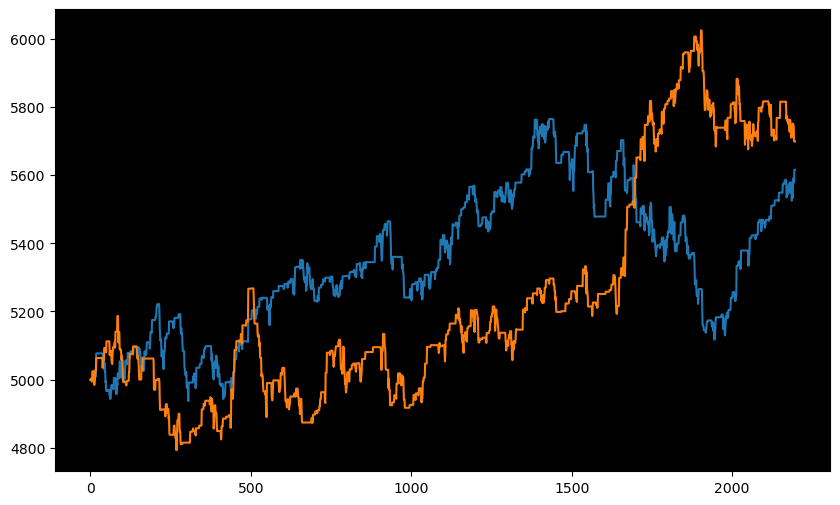

In [16]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=False).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')

In [17]:
[r["Return [%]"] for r in results]

[12.314851563040701, 13.975077692080612]

In [18]:
names

['EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'GBPUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']

In [19]:
results[1]

Start                     2017-06-06 00:00:00
End                       2024-06-14 00:00:00
Duration                   2565 days 00:00:00
Exposure Time [%]                   45.355191
Equity Final [$]                  5698.753885
Equity Peak [$]                   6025.001308
Return [%]                          13.975078
Buy & Hold Return [%]               -1.729428
Return (Ann.) [%]                    1.512417
Volatility (Ann.) [%]                4.607678
Sharpe Ratio                         0.328238
Sortino Ratio                        0.512531
Calmar Ratio                         0.199269
Max. Drawdown [%]                   -7.589835
Avg. Drawdown [%]                   -1.266538
Max. Drawdown Duration     1066 days 00:00:00
Avg. Drawdown Duration       78 days 00:00:00
# Trades                                  220
Win Rate [%]                        84.545455
Best Trade [%]                       1.791137
Worst Trade [%]                     -2.157145
Avg. Trade [%]                    